# $\mathrm{MGLYOX}$ (methylglyoxal)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

In [4]:
# load in spectrometer data
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
data = [
290	1	0.993030416
300	1	0.981081516
310	1	0.952710926
320	1	0.892510118
330	1	0.783124914
340	1	0.622525325
350	1	0.440624798
360	1	0.28161113
370	1	0.168454685
380	0.92	0.09696674
390	0.89	0.056109539
400	0.56	0.032126805
410	0.32	0.018768341
420	0.27	0.011457273
430	0.2	0.007092255
440	0.17	0.004497625    
]

λ = data[:,1]
Φ₁ = data[:,2]
Φ₂ = data[:,3]

16-element Vector{Float64}:
 0.993030416
 0.981081516
 0.952710926
 0.892510118
 0.783124914
 0.622525325
 0.440624798
 0.28161113
 0.168454685
 0.09696674
 0.056109539
 0.032126805
 0.018768341
 0.011457273
 0.007092255
 0.004497625

# Model Evaluation

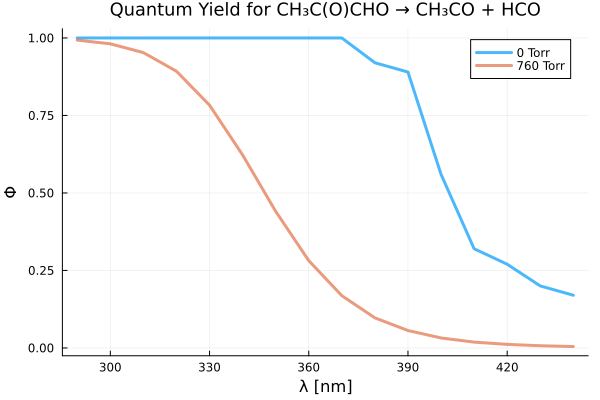

In [6]:
p = plot(
    λ,
    Φ₁,
    xlabel="λ [nm]",
    ylabel="Φ",
    alpha=0.7,
    lw=3,
    label="0 Torr",
    title="Quantum Yield for CH₃C(O)CHO → CH₃CO + HCO",
    titlefontsize=12,
)

plot!(
    λ,
    Φ₂,
    xlabel="λ [nm]",
    ylabel="Φ",
    alpha=0.7,
    lw=3,
    label="760 Torr",
    title="Quantum Yield for CH₃C(O)CHO → CH₃CO + HCO",
    titlefontsize=12,
)


# Output for Photolysis Rate Determination

In [7]:
df_photolysis_Φ = CSV.File("../photolysis_Φ.csv") |> DataFrame

Row,Φ_1,Φ_2,Φ_3,Φ_4,Φ_6,Φ_5,Φ_7,Φ_8,Φ_11,Φ_12,Φ_13,Φ_14,Φ_15,Φ_16,Φ_17,Φ_18,Φ_19,Φ_20,Φ_21,Φ_22,Φ_23,Φ_24,Φ_31,Φ_32,Φ_33
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
5,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
6,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
7,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
8,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
9,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


In [8]:
λ_min = minimum(λ)
λ_max = maximum(λ)

#println(λ_min, "\t", minimum(df_photolysis_σ.λ))
#println(λ_max, "\t", maximum(df_photolysis_σ.λ))

440.0

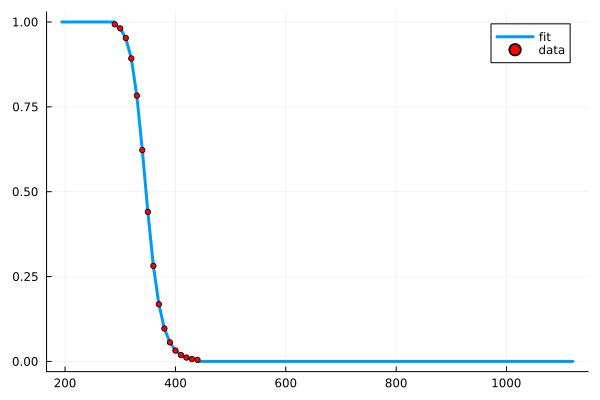

In [12]:
using DataInterpolations

cs = LinearInterpolation(Φ₂, λ)
Φ_out = cs(hr4000_df.λ)

# set anything outside of λ range to 0 as well
Φ_out[Φ_out .< 0.0] .= 0.0
Φ_out[ hr4000_df.λ .≥ λ_max] .= 0.0
Φ_out[hr4000_df.λ .≤ λ_min] .= 1.0


plot(hr4000_df.λ, Φ_out, lw=3, label="fit")
scatter!(λ, Φ₂, color=:red, ms=3, label="data")

In [13]:
df_photolysis_Φ.Φ_34 = Φ_out

describe(df_photolysis_Φ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,Φ_1,0.114981,0.0,0.0,1.0,0,Float64
2,Φ_2,0.885019,0.0,1.0,1.0,0,Float64
3,Φ_3,0.963542,0.0,1.0,1.0,0,Float64
4,Φ_4,0.214167,0.0,0.0,1.0,0,Float64
5,Φ_6,0.426121,0.0,0.0,1.0,0,Float64
6,Φ_5,0.00986771,0.0,0.0,0.344696,0,Float64
7,Φ_7,0.211623,0.0,0.0,1.0,0,Float64
8,Φ_8,0.945175,0.0,1.0,1.0,0,Float64
9,Φ_11,0.0470227,0.0,0.0,0.73106,0,Float64


In [14]:
CSV.write("../photolysis_Φ.csv", df_photolysis_Φ)

"../photolysis_Φ.csv"